In [1]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import shap

import sys
sys.path.append('/home/user/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import myfilter, num_transient, sliding_sum_window, select_index, add_padding
from PreProcessingFunctions import WS
from PreProcessingFunctions import rename_and_convert_to_txt

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, classification_report

import tensorflow
gpus = tensorflow.config.list_physical_devices('GPU')
if gpus:    
    for gpu in gpus:
        tensorflow.config.set_logical_device_configuration(
            gpu,
            [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import binary_crossentropy, categorical_crossentropy
from tensorflow.keras.metrics    import AUC, Precision, Recall
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

data_folder = '/home/user/thesis_ws/src/ML_ACTIONS/DATA/1D_FLAP_Fx+Fz_ScalNorm'

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data

# Load the data
X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

WS_B = 1800
N_CLASS = 3
DISP_LABELS = ["0", "1", "2"]

/home/user/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-29 18:59:11.399303: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-29 18:59:12.120207: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


X_data shape: (537, 1800, 2)
y_data shape: (537,)
X_data.[0] shape:  (1800, 2)
TOTAL DATA: 537  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (322, 1800, 2)    ||  Dimensions of y_train: (322,)
Dimensions of X_test:  (108, 1800, 2)    ||  Dimensions of y_test:  (108,)
Dimensions of X_val:   (107, 1800, 2)    ||  Dimensions of y_val:   (107,)


2024-05-29 18:59:12.601269: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 18:59:12.629566: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-29 18:59:12.629800: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# 1 CONVs

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 177, 64)   │      2,624 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 177, 64)   │      2,624 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_24    │ (None, 88, 64)    │          0 │ conv1d_26[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_25    │ (None, 88, 64)    │          0 │ conv1d_27[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_14          │ (None, 5632)      │          0 │ max_pooling1d_24… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_15          │ (None, 5632)      │          0 │ max_pooling1d_25… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 11264)     │          0 │ flatten_14[0][0], │
│ (Concatenate)       │                   │            │ flatten_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 64)        │    720,960 │ concatenate_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 3)         │        195 │ dense_14[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 726,403 (2.77 MB)

 Trainable params: 726,403 (2.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - accuracy: 0.4121 - loss: 1.1391 - val_accuracy: 0.5514 - val_loss: 0.8975
Epoch 2/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6689 - loss: 0.7539 - val_accuracy: 0.6822 - val_loss: 0.8473
Epoch 3/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6965 - loss: 0.6749 - val_accuracy: 0.7103 - val_loss: 0.8418
Epoch 4/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7205 - loss: 0.5701 - val_accuracy: 0.7103 - val_loss: 0.8673
Epoch 5/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7560 - loss: 0.5360 - val_accuracy: 0.6636 - val_loss: 0.9314
Epoch 6/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6599 - loss: 0.6978 - val_accuracy: 0.7757 - val_loss: 0.8125
Epoch 7/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7768 - loss: 0.5214 - val_accuracy: 0.7850 - val_loss: 0.8443
Epoch 8/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7822 - loss: 0.4719 - val_accuracy: 0.7196 - val_loss

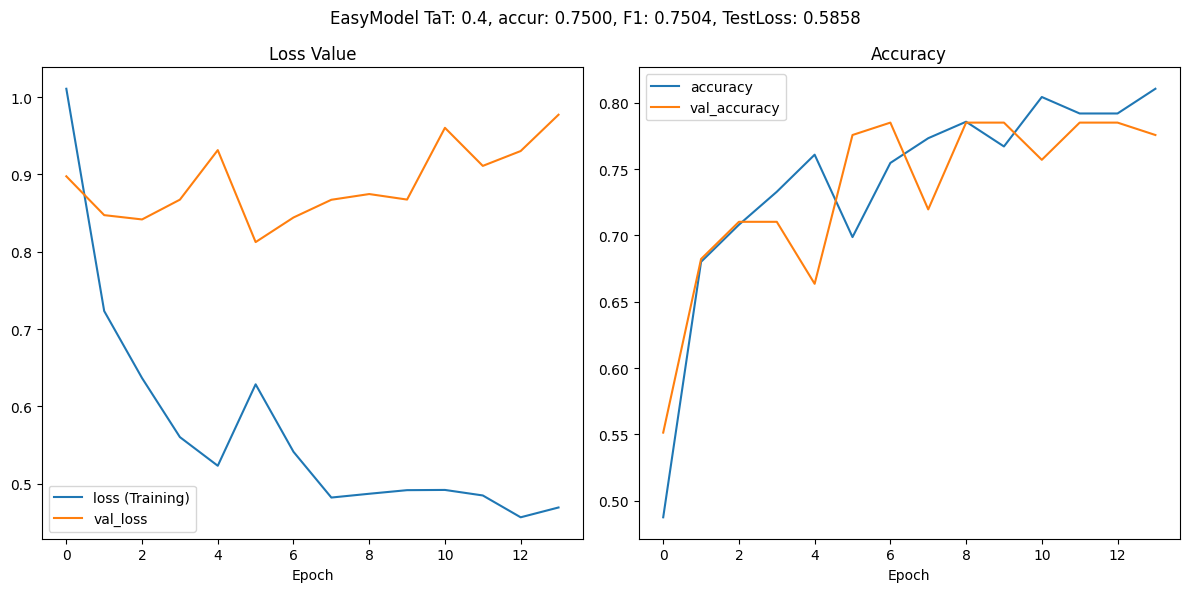

Train loss: 0.46931636333465576
Test val_loss: 0.9771451354026794
Train accuracy: 0.8105590343475342
Accuracy Score: 0.75
F1 Score: 0.7503501475621869
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.84      0.76        32
         1.0       0.76      0.62      0.68        40
         2.0       0.81      0.81      0.81        36

    accuracy                           0.75       108
   macro avg       0.75      0.76      0.75       108
weighted avg       0.75      0.75      0.75       108



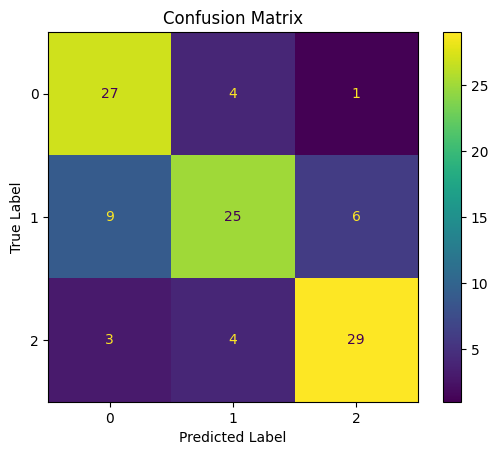

In [11]:
def build_easyModel():
    input_layer = Input(shape=(WS_B, 1))
    x = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(64, kernel_size=40, strides=10, activation='relu')(input_layer)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)
    model = Model(inputs=[input_layer, input_layer], outputs=output_layer)
    return model

model_name = "1D_easy1Conv"
model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 2 CONVs 

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 448, 128)  │      1,408 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 448, 128)  │      1,408 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_26    │ (None, 224, 128)  │          0 │ conv1d_28[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_28    │ (None, 224, 128)  │          0 │ conv1d_30[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_29 (Conv1D)  │ (None, 221, 64)   │     32,832 │ max_pooling1d_26… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 221, 64)   │     32,832 │ max_pooling1d_28… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_27    │ (None, 110, 64)   │          0 │ conv1d_29[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_29    │ (None, 110, 64)   │          0 │ conv1d_31[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_16          │ (None, 7040)      │          0 │ max_pooling1d_27… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_17          │ (None, 7040)      │          0 │ max_pooling1d_29… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 14080)     │          0 │ flatten_16[0][0], │
│ (Concatenate)       │                   │            │ flatten_17[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 14080)     │          0 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │    901,184 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 3)         │        195 │ dense_16[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 969,859 (3.70 MB)

 Trainable params: 969,859 (3.70 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 174ms/step - accuracy: 0.5323 - loss: 1.0205 - val_accuracy: 0.5794 - val_loss: 0.9597
Epoch 2/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6262 - loss: 0.7771 - val_accuracy: 0.6729 - val_loss: 0.9143
Epoch 3/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6584 - loss: 0.7898 - val_accuracy: 0.6542 - val_loss: 0.8624
Epoch 4/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7226 - loss: 0.6012 - val_accuracy: 0.6542 - val_loss: 0.8102
Epoch 5/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6808 - loss: 0.6416 - val_accuracy: 0.7383 - val_loss: 0.8397
Epoch 6/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7103 - loss: 0.6362 - val_accuracy: 0.6822 - val_loss: 0.9677
Epoch 7/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7268 - loss: 0.5768 - val_accuracy: 0.7850 - val_loss: 0.7752
Epoch 8/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7856 - loss: 0.4392 - val_accuracy: 0.7383 - val_los

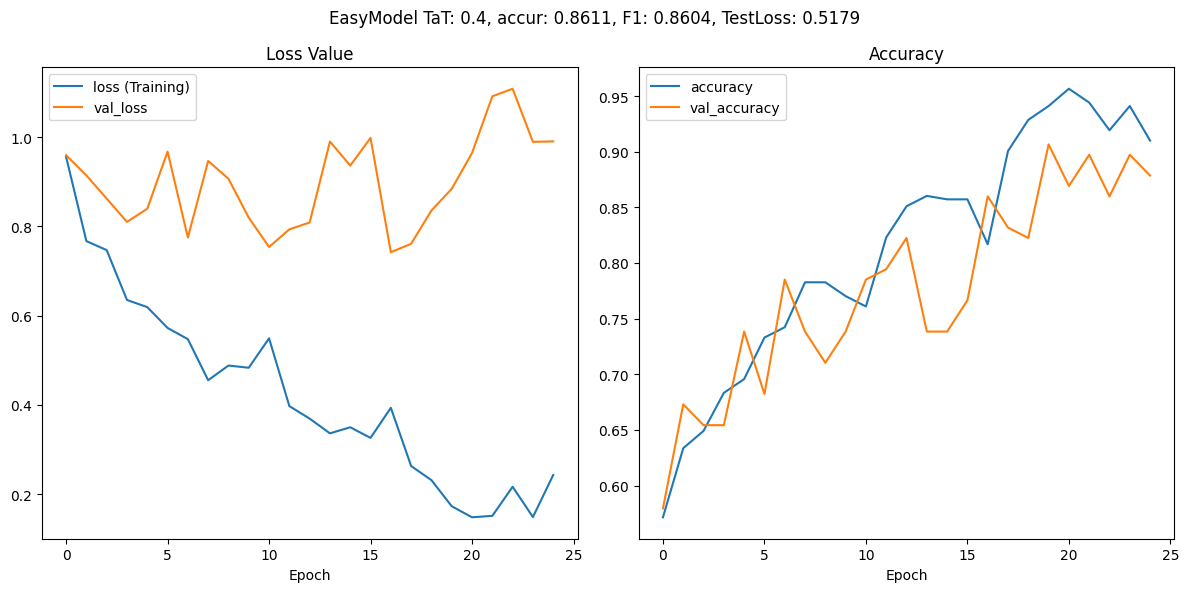

Train loss: 0.2429560124874115
Test val_loss: 0.9905698299407959
Train accuracy: 0.909937858581543
Accuracy Score: 0.8611111111111112
F1 Score: 0.860387393339144
Classification Report:
               precision    recall  f1-score   support

         0.0       0.93      0.78      0.85        32
         1.0       0.80      0.93      0.86        40
         2.0       0.89      0.86      0.87        36

    accuracy                           0.86       108
   macro avg       0.87      0.86      0.86       108
weighted avg       0.87      0.86      0.86       108



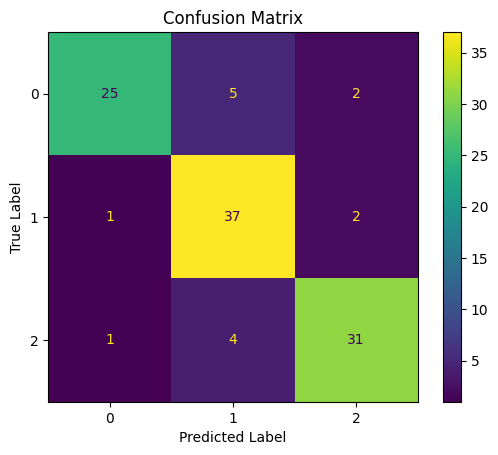

In [12]:
def build_easyModel():
    input = Input(shape=(WS_B, 1))

    x = Conv1D(128, kernel_size=10, strides=4, activation='relu')(input)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(64, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(128, kernel_size=10, strides=4, activation='relu')(input)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(64, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    merged = Dropout(0.2)(merged)
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input, input], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# model_name = "1D_LDG_F+F_2Cnv_94"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 3 CONVs

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_26      │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 177, 256)  │     10,496 │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_79 (Conv1D)  │ (None, 177, 256)  │     10,496 │ input_layer_26[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_72    │ (None, 88, 256)   │          0 │ conv1d_76[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_75    │ (None, 88, 256)   │          0 │ conv1d_79[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_77 (Conv1D)  │ (None, 21, 128)   │    262,272 │ max_pooling1d_72… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_80 (Conv1D)  │ (None, 21, 128)   │    262,272 │ max_pooling1d_75… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_73    │ (None, 10, 128)   │          0 │ conv1d_77[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_76    │ (None, 10, 128)   │          0 │ conv1d_80[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 9, 128)    │     32,896 │ max_pooling1d_73… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_81 (Conv1D)  │ (None, 9, 128)    │     32,896 │ max_pooling1d_76… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_74    │ (None, 4, 128)    │          0 │ conv1d_78[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_77    │ (None, 4, 128)    │          0 │ conv1d_81[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_32          │ (None, 512)       │          0 │ max_pooling1d_74… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_33          │ (None, 512)       │          0 │ max_pooling1d_77… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 1024)      │          0 │ flatten_32[0][0], │
│ (Concatenate)       │                   │            │ flatten_33[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 128)       │    131,200 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_13          │ (None, 128)       │          0 │ dense_32[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 742,915 (2.83 MB)

 Trainable params: 742,915 (2.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - accuracy: 0.4260 - loss: 1.0607 - val_accuracy: 0.6729 - val_loss: 0.7948
Epoch 2/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7235 - loss: 0.6148 - val_accuracy: 0.7570 - val_loss: 0.6721
Epoch 3/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7856 - loss: 0.4457 - val_accuracy: 0.7664 - val_loss: 0.5819
Epoch 4/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7819 - loss: 0.4833 - val_accuracy: 0.6262 - val_loss: 0.8864
Epoch 5/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7048 - loss: 0.6506 - val_accuracy: 0.7290 - val_loss: 0.6915
Epoch 6/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7913 - loss: 0.4773 - val_accuracy: 0.8224 - val_loss: 0.5607
Epoch 7/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8342 - loss: 0.4134 - val_accuracy: 0.7290 - val_loss: 0.6659
Epoch 8/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8307 - loss: 0.3903 - val_accuracy: 0.8224 - val_lo

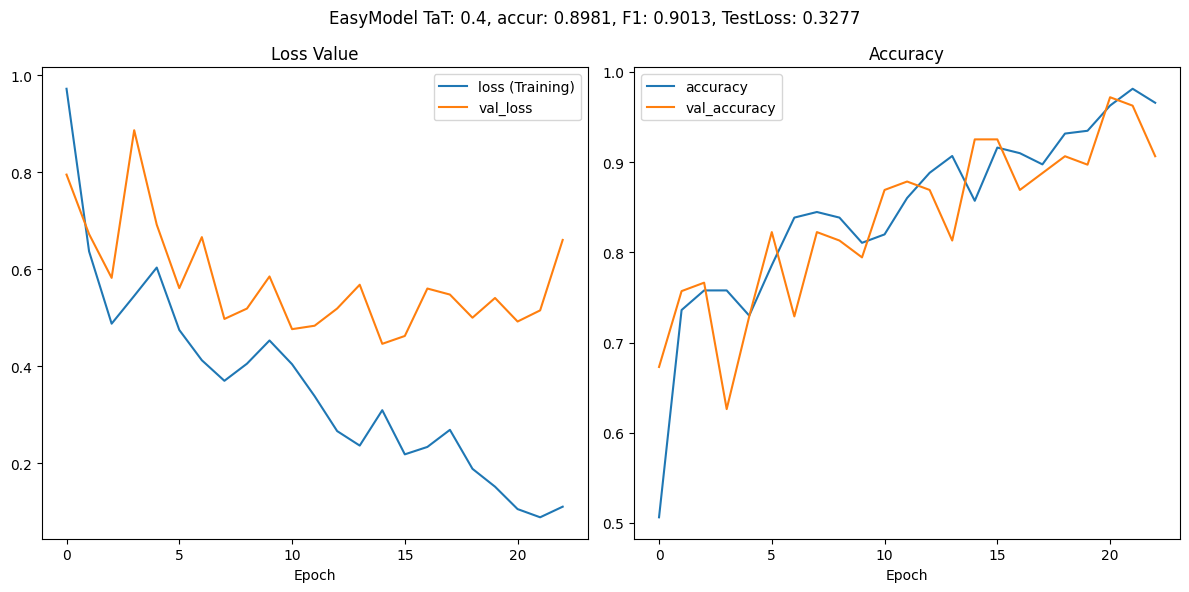

Train loss: 0.10997253656387329
Test val_loss: 0.6600799560546875
Train accuracy: 0.9658384919166565
Accuracy Score: 0.8981481481481481
F1 Score: 0.901306296043138
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.94      0.95        32
         1.0       0.92      0.82      0.87        40
         2.0       0.83      0.94      0.88        36

    accuracy                           0.90       108
   macro avg       0.90      0.90      0.90       108
weighted avg       0.90      0.90      0.90       108



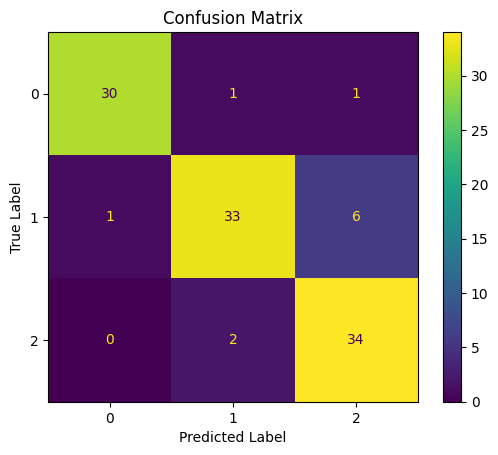

In [22]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    x = Conv1D(256, kernel_size=40, strides=10, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=8, strides=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(128, kernel_size=2, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    z = Conv1D(256, kernel_size=40, strides=10, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=8, strides=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(128, kernel_size=2, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    merged = concatenate([x, z])
    common_layer = Dense(128, activation='relu')(merged)
    common_layer = Dropout(0.2)(common_layer)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model

model = build_easyModel()
model.summary()
model.compile(optimizer=AdamW(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# model_name = "1D_FLAP_F+F_4Cnv_98"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 4 CONVs or Still "COMPLEX"

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 1800, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 446, 256)  │      5,376 │ input_layer_13[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 446, 256)  │      5,376 │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_36    │ (None, 223, 256)  │          0 │ conv1d_38[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_39    │ (None, 223, 256)  │          0 │ conv1d_42[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 52, 256)   │  1,048,832 │ max_pooling1d_36… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 52, 256)   │  1,048,832 │ max_pooling1d_39… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 52, 256)   │          0 │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 52, 256)   │          0 │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 45, 128)   │    262,272 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 45, 128)   │    262,272 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_37    │ (None, 22, 128)   │          0 │ conv1d_40[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_40    │ (None, 22, 128)   │          0 │ conv1d_44[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 19, 64)    │     32,832 │ max_pooling1d_37… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 19, 64)    │     32,832 │ max_pooling1d_40… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_38    │ (None, 9, 64)     │          0 │ conv1d_41[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_41    │ (None, 9, 64)     │          0 │ conv1d_45[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_20          │ (None, 576)       │          0 │ max_pooling1d_38… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_21          │ (None, 576)       │          0 │ max_pooling1d_41… │
│ (Flatten)           │                   │            │                 

 Total params: 2,772,611 (10.58 MB)

 Trainable params: 2,772,611 (10.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 318ms/step - accuracy: 0.4469 - loss: 0.9415 - val_accuracy: 0.5607 - val_loss: 1.1317
Epoch 2/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5886 - loss: 0.9223 - val_accuracy: 0.6262 - val_loss: 0.8444
Epoch 3/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5578 - loss: 0.8880 - val_accuracy: 0.7570 - val_loss: 0.6739
Epoch 4/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7646 - loss: 0.5414 - val_accuracy: 0.8037 - val_loss: 0.7411
Epoch 5/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8115 - loss: 0.4244 - val_accuracy: 0.8131 - val_loss: 0.6299
Epoch 6/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8805 - loss: 0.3312 - val_accuracy: 0.8505 - val_loss: 0.5909
Epoch 7/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8997 - loss: 0.2714 - val_accuracy: 0.8318 - val_loss: 0.6988
Epoch 8/32
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8685 - loss: 0.3240 - val_accuracy: 0.8785 - 

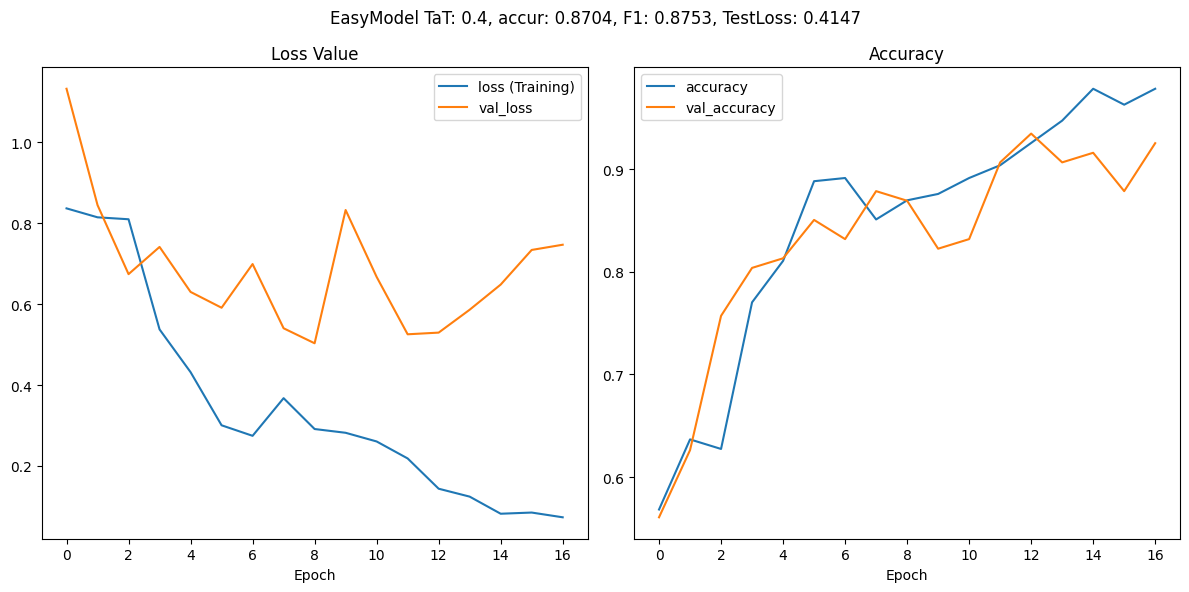

Train loss: 0.07329440116882324
Test val_loss: 0.7465150952339172
Train accuracy: 0.97826087474823
Accuracy Score: 0.8703703703703703
F1 Score: 0.8753200204813107
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.91      0.94        32
         1.0       0.80      0.88      0.83        40
         2.0       0.88      0.83      0.86        36

    accuracy                           0.87       108
   macro avg       0.88      0.87      0.88       108
weighted avg       0.88      0.87      0.87       108



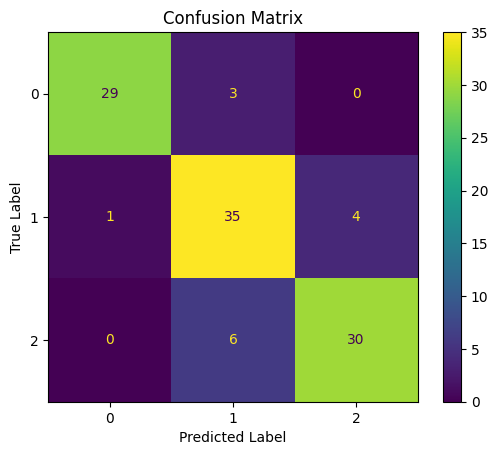

In [15]:
def build_easyModel():
    input_x = Input(shape=(WS_B, 1))
    input_z = Input(shape=(WS_B, 1))

    # Branch for Force_X
    x = Conv1D(filters=256, kernel_size=20, strides=4, activation='relu')(input_x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')(x)
    x = Dropout(rate=0.1)(x)
    x = Conv1D(filters=128, kernel_size=8, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=4, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    # Branch for Force_Z
    z = Conv1D(filters=256, kernel_size=20, strides=4, activation='relu')(input_z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=256, kernel_size=16, strides=4, activation='relu')(z)
    z = Dropout(rate=0.1)(z)
    z = Conv1D(filters=128, kernel_size=8, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Conv1D(filters=64, kernel_size=4, activation='relu')(z)
    z = MaxPooling1D(pool_size=2)(z)
    z = Flatten()(z)

    # Merging branches
    merged = concatenate([x, z])
    common_layer = Dense(64, activation='relu')(merged)
    output_layer = Dense(N_CLASS, activation='softmax')(common_layer)

    model = Model(inputs=[input_x, input_z], outputs=output_layer)
    return model


model = build_easyModel()
model.summary()
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# SPLITTING DATASET x+z
X_x_data = X_data[:, :, 0]
X_z_data  = X_data[:, :, 1]

X_train_x,  X_temp_x = train_test_split(X_x_data, test_size=TEST_SIZE, random_state=42)
X_val_x,    X_test_x = train_test_split(X_temp_x , test_size=0.5, random_state=42)

X_train_z,   X_temp_z  = train_test_split(X_z_data, test_size=TEST_SIZE, random_state=42)
X_val_z,     X_test_z  = train_test_split(X_temp_z , test_size=0.5, random_state=42)

y_train, y_temp = train_test_split(y_data, test_size=TEST_SIZE, random_state=42)
y_val  , y_test = train_test_split(y_temp, test_size=0.5, random_state=42)

#TRAIN THE MODEL
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = model.fit([X_train_x, X_train_z], y_train, epochs=32, batch_size=32, 
                    validation_data=([X_val_x, X_val_z], y_val), verbose=1, callbacks=[early_stopping])

loss, accuracy = model.evaluate([X_test_x, X_test_z], y_test)

# Predict labels for test data
y_pred = model.predict([X_test_x, X_test_z])
y_pred_labels = np.argmax(y_pred, axis=1)

f1 = f1_score(y_test, y_pred_labels, average='macro')
accuracy = accuracy_score(y_test, y_pred_labels)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# Plot Loss Value
axs[0].plot(history.history["loss"], label="loss (Training)")
axs[0].plot(history.history["val_loss"], label="val_loss")
axs[0].set_title("Loss Value")
axs[0].set_xlabel('Epoch')
axs[0].legend()

# Plot Accuracy
axs[1].plot(history.history["accuracy"], label="accuracy")
axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
axs[1].set_title("Accuracy")
axs[1].set_xlabel('Epoch')
axs[1].legend()
plt.suptitle(f"EasyModel TaT: {TEST_SIZE}, accur: {accuracy:.4f}, F1: {f1:.4f}, TestLoss: {loss:.4f}")
plt.tight_layout()
plt.show()

print("Train loss:", history.history["loss"][-1])
print("Test val_loss:", history.history["val_loss"][-1])
print("Train accuracy:", history.history["accuracy"][-1])
print("Accuracy Score:", accuracy)

print("F1 Score:", f1)
print("Classification Report:\n", classification_report(y_test, y_pred_labels))

conf_mat = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=DISP_LABELS)
disp.plot()  # You can adjust the colormap as needed
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [16]:
# model_name = "1D_FLAP_F+F_4Cnv_98"
# to_save_model(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_easyModel)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

# 5 CONVS